## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -1.252423     584.398073   -21.601480     -26.402849   
1            2     -1.252423     584.398073   -21.601480     -26.402849   
2            3     -1.252423     584.398073   -21.601480     -26.402849   
3            4     -1.252423     584.398073   -21.601480     -26.402849   
4            5     -1.252423     584.398073   -21.601480     -26.402849   
...        ...           ...            ...          ...            ...   
1752345     46     -3.068643     528.790329   -15.910644     -20.374966   
1752346     47     -3.068643     528.790329   -15.910644     -20.374966   
1752347     48     -3.068643     528.790329   -15.910644     -20.374966   
1752348     49     -3.068643     528.790329   -15.910644     -20.374966   
1752349     50     -3.068643     528.790329   -15.910644     -20.374966   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat01']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',
                   'temp_conv04']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)

        m1_pred = heat_diff_model(m1_input)

        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))


        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.005494097
RMSE of after m1 0.06835441
RMSE of after m3 0.06951313
RMSE of after m4 0.07095802
RMSE of after m0 0.0072544105
RMSE of after m1 0.044006016
RMSE of after m3 0.04750072
RMSE of after m4 0.047506824
RMSE of after m0 0.006148237
RMSE of after m1 0.044652816
RMSE of after m3 0.047294736
RMSE of after m4 0.0501875
RMSE of after m0 0.006151012
RMSE of after m1 0.020332014
RMSE of after m3 0.022672055
RMSE of after m4 0.044504885
RMSE of after m0 0.0035043687
RMSE of after m1 0.025905332
RMSE of after m3 0.024986053
RMSE of after m4 0.025329039
RMSE of after m0 0.0035139145
RMSE of after m1 0.022006067
RMSE of after m3 0.021118915
RMSE of after m4 0.022163862
RMSE of after m0 0.004039306
RMSE of after m1 0.021178987
RMSE of after m3 0.023020273
RMSE of after m4 0.023840066
RMSE of after m0 0.0040400084
RMSE of after m1 0.021603229
RMSE of after m3 0.02299716
RMSE of after m4 0.02365847
RMSE of after m0 0.003603099
RMSE of after m1 0.01939221
RMSE of after m3 0.

RMSE of after m3 0.0208743
RMSE of after m4 0.027151741
RMSE of after m0 0.0063785226
RMSE of after m1 0.018037427
RMSE of after m3 0.021627428
RMSE of after m4 0.023927754
RMSE of after m0 0.005579195
RMSE of after m1 0.015458554
RMSE of after m3 0.021022908
RMSE of after m4 0.02546606
RMSE of after m0 0.0055419668
RMSE of after m1 0.01741592
RMSE of after m3 0.02182086
RMSE of after m4 0.026973069
RMSE of after m0 0.0060179327
RMSE of after m1 0.017832203
RMSE of after m3 0.02098209
RMSE of after m4 0.026218096
RMSE of after m0 0.014460284
RMSE of after m1 0.05179525
RMSE of after m3 0.050319247
RMSE of after m4 0.061071787
RMSE of after m0 0.007144019
RMSE of after m1 0.02746362
RMSE of after m3 0.028721105
RMSE of after m4 0.032183267
RMSE of after m0 0.0086197695
RMSE of after m1 0.040911965
RMSE of after m3 0.0410157
RMSE of after m4 0.04395894
RMSE of after m0 0.0068173497
RMSE of after m1 0.0487123
RMSE of after m3 0.049742498
RMSE of after m4 0.057665635
RMSE of after m0 0.006

RMSE of after m0 0.0076443437
RMSE of after m1 0.014209128
RMSE of after m3 0.018678084
RMSE of after m4 0.020793423
RMSE of after m0 0.0078006675
RMSE of after m1 0.014035237
RMSE of after m3 0.017551603
RMSE of after m4 0.019542053
RMSE of after m0 0.00663237
RMSE of after m1 0.018591499
RMSE of after m3 0.023637349
RMSE of after m4 0.025396878
RMSE of after m0 0.0042079003
RMSE of after m1 0.026287092
RMSE of after m3 0.026502172
RMSE of after m4 0.026985427
RMSE of after m0 0.003881737
RMSE of after m1 0.015792452
RMSE of after m3 0.017244084
RMSE of after m4 0.018225107
RMSE of after m0 0.0044734706
RMSE of after m1 0.009393035
RMSE of after m3 0.016097255
RMSE of after m4 0.016971713
RMSE of after m0 0.0066359094
RMSE of after m1 0.013100852
RMSE of after m3 0.016128885
RMSE of after m4 0.017947549
RMSE of after m0 0.0050870385
RMSE of after m1 0.026117407
RMSE of after m3 0.024353212
RMSE of after m4 0.024501076
RMSE of after m0 0.004865305
RMSE of after m1 0.010234463
RMSE of a

RMSE of after m1 0.018935075
RMSE of after m3 0.018160723
RMSE of after m4 0.020043263
RMSE of after m0 0.0064264378
RMSE of after m1 0.02059189
RMSE of after m3 0.01865604
RMSE of after m4 0.020891648
RMSE of after m0 0.006289087
RMSE of after m1 0.02698435
RMSE of after m3 0.021963904
RMSE of after m4 0.023966542
RMSE of after m0 0.0066520185
RMSE of after m1 0.026101263
RMSE of after m3 0.019603891
RMSE of after m4 0.02204251
RMSE of after m0 0.008898701
RMSE of after m1 0.033250876
RMSE of after m3 0.03664598
RMSE of after m4 0.03726306
RMSE of after m0 0.008998217
RMSE of after m1 0.03086851
RMSE of after m3 0.04243026
RMSE of after m4 0.04226187
RMSE of after m0 0.0071865045
RMSE of after m1 0.023689125
RMSE of after m3 0.02459612
RMSE of after m4 0.025631472
RMSE of after m0 0.0064399606
RMSE of after m1 0.019777728
RMSE of after m3 0.021125972
RMSE of after m4 0.022521235
RMSE of after m0 0.007727216
RMSE of after m1 0.037468653
RMSE of after m3 0.043440517
RMSE of after m4 0.0

RMSE of after m3 0.018022675
RMSE of after m4 0.017701566
RMSE of after m0 0.0042288974
RMSE of after m1 0.017453657
RMSE of after m3 0.015071541
RMSE of after m4 0.01612537
RMSE of after m0 0.005639383
RMSE of after m1 0.011831675
RMSE of after m3 0.02052328
RMSE of after m4 0.021250138
RMSE of after m0 0.0056643365
RMSE of after m1 0.022839261
RMSE of after m3 0.02633594
RMSE of after m4 0.02718849
RMSE of after m0 0.004733397
RMSE of after m1 0.014646583
RMSE of after m3 0.018194048
RMSE of after m4 0.017489392
RMSE of after m0 0.0054185265
RMSE of after m1 0.01584215
RMSE of after m3 0.019581696
RMSE of after m4 0.018519849
RMSE of after m0 0.0075656674
RMSE of after m1 0.021130338
RMSE of after m3 0.023539184
RMSE of after m4 0.024131501
RMSE of after m0 0.015837427
RMSE of after m1 0.07629455
RMSE of after m3 0.09772243
RMSE of after m4 0.09960767
RMSE of after m0 0.010021816
RMSE of after m1 0.059562355
RMSE of after m3 0.077433385
RMSE of after m4 0.0783381
RMSE of after m0 0.0

RMSE of after m4 0.019749144
RMSE of after m0 0.0068831425
RMSE of after m1 0.018608041
RMSE of after m3 0.017382775
RMSE of after m4 0.024302943
RMSE of after m0 0.007278001
RMSE of after m1 0.015967652
RMSE of after m3 0.016079122
RMSE of after m4 0.021554383
RMSE of after m0 0.007405734
RMSE of after m1 0.014219284
RMSE of after m3 0.015780458
RMSE of after m4 0.019763932
RMSE of after m0 0.006515438
RMSE of after m1 0.013467039
RMSE of after m3 0.014289388
RMSE of after m4 0.02034786
RMSE of after m0 0.007129516
RMSE of after m1 0.014358586
RMSE of after m3 0.01606333
RMSE of after m4 0.020624306
RMSE of after m0 0.0075095175
RMSE of after m1 0.009881932
RMSE of after m3 0.011725648
RMSE of after m4 0.019011706
RMSE of after m0 0.008875666
RMSE of after m1 0.015477098
RMSE of after m3 0.017693853
RMSE of after m4 0.02579704
RMSE of after m0 0.008821918
RMSE of after m1 0.013235246
RMSE of after m3 0.015568704
RMSE of after m4 0.023603404
RMSE of after m0 0.025862936
RMSE of after m

RMSE of after m0 0.008995525
RMSE of after m1 0.016430054
RMSE of after m3 0.021851359
RMSE of after m4 0.049032696
RMSE of after m0 0.008797509
RMSE of after m1 0.016710939
RMSE of after m3 0.022832595
RMSE of after m4 0.045198917
RMSE of after m0 0.0068174014
RMSE of after m1 0.013287576
RMSE of after m3 0.020151615
RMSE of after m4 0.034262944
RMSE of after m0 0.0094282
RMSE of after m1 0.018198937
RMSE of after m3 0.02490324
RMSE of after m4 0.046322867
RMSE of after m0 0.01126837
RMSE of after m1 0.021890685
RMSE of after m3 0.029085316
RMSE of after m4 0.053930406
RMSE of after m0 0.007407317
RMSE of after m1 0.014810597
RMSE of after m3 0.020734042
RMSE of after m4 0.0360348
RMSE of after m0 0.009425029
RMSE of after m1 0.020647692
RMSE of after m3 0.02732884
RMSE of after m4 0.04862978
RMSE of after m0 0.012020702
RMSE of after m1 0.025397392
RMSE of after m3 0.029130975
RMSE of after m4 0.060173325
RMSE of after m0 0.016036082
RMSE of after m1 0.04455576
RMSE of after m3 0.049

RMSE of after m1 0.15498689
RMSE of after m3 0.15372375
RMSE of after m4 0.2127446
RMSE of after m0 0.009924332
RMSE of after m1 0.08029081
RMSE of after m3 0.082375124
RMSE of after m4 0.090625934
RMSE of after m0 0.007926689
RMSE of after m1 0.05966712
RMSE of after m3 0.061059438
RMSE of after m4 0.07280471
RMSE of after m0 0.0059610405
RMSE of after m1 0.054365728
RMSE of after m3 0.055942036
RMSE of after m4 0.06100458
RMSE of after m0 0.005401848
RMSE of after m1 0.01632709
RMSE of after m3 0.021291498
RMSE of after m4 0.024036419
RMSE of after m0 0.005398157
RMSE of after m1 0.013277592
RMSE of after m3 0.017895173
RMSE of after m4 0.026329117
RMSE of after m0 0.0063986885
RMSE of after m1 0.023525061
RMSE of after m3 0.026904397
RMSE of after m4 0.03255921
RMSE of after m0 0.0066195563
RMSE of after m1 0.03859608
RMSE of after m3 0.039082903
RMSE of after m4 0.047493648
RMSE of after m0 0.0052781147
RMSE of after m1 0.016246427
RMSE of after m3 0.015600544
RMSE of after m4 0.02

RMSE of after m3 0.02548633
RMSE of after m4 0.027108394
RMSE of after m0 0.0059415842
RMSE of after m1 0.018631164
RMSE of after m3 0.021484379
RMSE of after m4 0.02333686
RMSE of after m0 0.005014593
RMSE of after m1 0.011997938
RMSE of after m3 0.01599559
RMSE of after m4 0.01758078
RMSE of after m0 0.0049305432
RMSE of after m1 0.015153693
RMSE of after m3 0.019134125
RMSE of after m4 0.02044371
RMSE of after m0 0.0046222075
RMSE of after m1 0.008837307
RMSE of after m3 0.014249323
RMSE of after m4 0.015863707
RMSE of after m0 0.0049791196
RMSE of after m1 0.010808983
RMSE of after m3 0.014061742
RMSE of after m4 0.015946265
RMSE of after m0 0.0051271254
RMSE of after m1 0.012392927
RMSE of after m3 0.013898001
RMSE of after m4 0.015826097
RMSE of after m0 0.0049751005
RMSE of after m1 0.016306292
RMSE of after m3 0.017042654
RMSE of after m4 0.019086968
RMSE of after m0 0.004964142
RMSE of after m1 0.018612592
RMSE of after m3 0.016611923
RMSE of after m4 0.019250417
RMSE of after

RMSE of after m0 0.0073653916
RMSE of after m1 0.025887324
RMSE of after m3 0.03288386
RMSE of after m4 0.033805996
RMSE of after m0 0.007628883
RMSE of after m1 0.031556975
RMSE of after m3 0.03409779
RMSE of after m4 0.035289753
RMSE of after m0 0.005011185
RMSE of after m1 0.016622366
RMSE of after m3 0.017723892
RMSE of after m4 0.019792438
RMSE of after m0 0.0054874145
RMSE of after m1 0.014650045
RMSE of after m3 0.014297515
RMSE of after m4 0.017169433
RMSE of after m0 0.011352413
RMSE of after m1 0.03796445
RMSE of after m3 0.054228418
RMSE of after m4 0.054919977
RMSE of after m0 0.013161062
RMSE of after m1 0.05086264
RMSE of after m3 0.06723278
RMSE of after m4 0.06790606
RMSE of after m0 0.008104302
RMSE of after m1 0.03662118
RMSE of after m3 0.052017767
RMSE of after m4 0.05299963
RMSE of after m0 0.006484318
RMSE of after m1 0.01669813
RMSE of after m3 0.017501678
RMSE of after m4 0.019371718
RMSE of after m0 0.0065728724
RMSE of after m1 0.011384604
RMSE of after m3 0.0

RMSE of after m1 0.013163353
RMSE of after m3 0.031654738
RMSE of after m4 0.032374755
RMSE of after m0 0.007122265
RMSE of after m1 0.013629368
RMSE of after m3 0.02778699
RMSE of after m4 0.028352689
RMSE of after m0 0.009282891
RMSE of after m1 0.02015199
RMSE of after m3 0.0364339
RMSE of after m4 0.036317527
RMSE of after m0 0.004045928
RMSE of after m1 0.03340785
RMSE of after m3 0.028753003
RMSE of after m4 0.029402908
RMSE of after m0 0.0038909612
RMSE of after m1 0.025749795
RMSE of after m3 0.021428738
RMSE of after m4 0.021633452
RMSE of after m0 0.00623301
RMSE of after m1 0.011420731
RMSE of after m3 0.023875425
RMSE of after m4 0.024137774
RMSE of after m0 0.009860632
RMSE of after m1 0.014463355
RMSE of after m3 0.029104145
RMSE of after m4 0.03005509
RMSE of after m0 0.0036693253
RMSE of after m1 0.019062446
RMSE of after m3 0.025428921
RMSE of after m4 0.0251394
RMSE of after m0 0.005002198
RMSE of after m1 0.026930023
RMSE of after m3 0.028230153
RMSE of after m4 0.02

RMSE of after m1 0.016793085
RMSE of after m3 0.021254998
RMSE of after m4 0.033966016
RMSE of after m0 0.01033269
RMSE of after m1 0.016691681
RMSE of after m3 0.020257732
RMSE of after m4 0.02737738
RMSE of after m0 0.007653992
RMSE of after m1 0.009907026
RMSE of after m3 0.012284106
RMSE of after m4 0.017981391
RMSE of after m0 0.0076418025
RMSE of after m1 0.010281723
RMSE of after m3 0.014441663
RMSE of after m4 0.013642437
RMSE of after m0 0.007966853
RMSE of after m1 0.010457042
RMSE of after m3 0.014119947
RMSE of after m4 0.015687272
RMSE of after m0 0.012371693
RMSE of after m1 0.04394346
RMSE of after m3 0.047945328
RMSE of after m4 0.05376981
RMSE of after m0 0.014661384
RMSE of after m1 0.053300846
RMSE of after m3 0.056372188
RMSE of after m4 0.05920152
RMSE of after m0 0.008461776
RMSE of after m1 0.023639495
RMSE of after m3 0.026652707
RMSE of after m4 0.032403383
RMSE of after m0 0.008295472
RMSE of after m1 0.017889488
RMSE of after m3 0.02076126
RMSE of after m4 0.

RMSE of after m1 0.01942912
RMSE of after m3 0.026547862
RMSE of after m4 0.03635917
RMSE of after m0 0.012776718
RMSE of after m1 0.023927648
RMSE of after m3 0.030425506
RMSE of after m4 0.040124174
RMSE of after m0 0.012190633
RMSE of after m1 0.02314895
RMSE of after m3 0.030497566
RMSE of after m4 0.03934341
RMSE of after m0 0.010338865
RMSE of after m1 0.019199869
RMSE of after m3 0.026707519
RMSE of after m4 0.031543285
RMSE of after m0 0.0116381375
RMSE of after m1 0.024054997
RMSE of after m3 0.030845737
RMSE of after m4 0.034012537
RMSE of after m0 0.014640789
RMSE of after m1 0.023781504
RMSE of after m3 0.030197578
RMSE of after m4 0.039424695
RMSE of after m0 0.012691592
RMSE of after m1 0.02121297
RMSE of after m3 0.02775195
RMSE of after m4 0.03617358
RMSE of after m0 0.011143141
RMSE of after m1 0.018423427
RMSE of after m3 0.025029426
RMSE of after m4 0.030419767
RMSE of after m0 0.01073551
RMSE of after m1 0.015716154
RMSE of after m3 0.020808917
RMSE of after m4 0.02

RMSE of after m1 0.025559897
RMSE of after m3 0.025903217
RMSE of after m4 0.03230123
RMSE of after m0 0.043917213
RMSE of after m1 0.12207886
RMSE of after m3 0.11776594
RMSE of after m4 0.11846135
RMSE of after m0 0.01572147
RMSE of after m1 0.020607775
RMSE of after m3 0.023360424
RMSE of after m4 0.025348375
RMSE of after m0 0.014008314
RMSE of after m1 0.06192921
RMSE of after m3 0.060147256
RMSE of after m4 0.05963692
RMSE of after m0 0.0045578955
RMSE of after m1 0.033755973
RMSE of after m3 0.035637397
RMSE of after m4 0.03617967
RMSE of after m0 0.004623341
RMSE of after m1 0.019338299
RMSE of after m3 0.023351135
RMSE of after m4 0.024283424
RMSE of after m0 0.0038930848
RMSE of after m1 0.033478726
RMSE of after m3 0.033412922
RMSE of after m4 0.03515373
RMSE of after m0 0.004318681
RMSE of after m1 0.01136257
RMSE of after m3 0.022746071
RMSE of after m4 0.024313625
RMSE of after m0 0.0060102777
RMSE of after m1 0.014805764
RMSE of after m3 0.020963248
RMSE of after m4 0.02

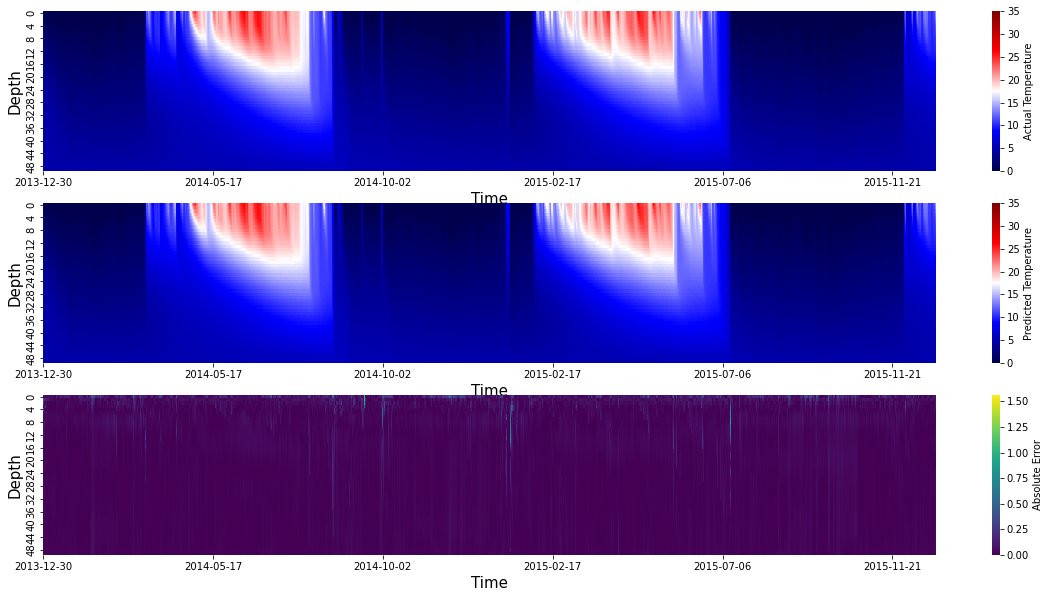

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

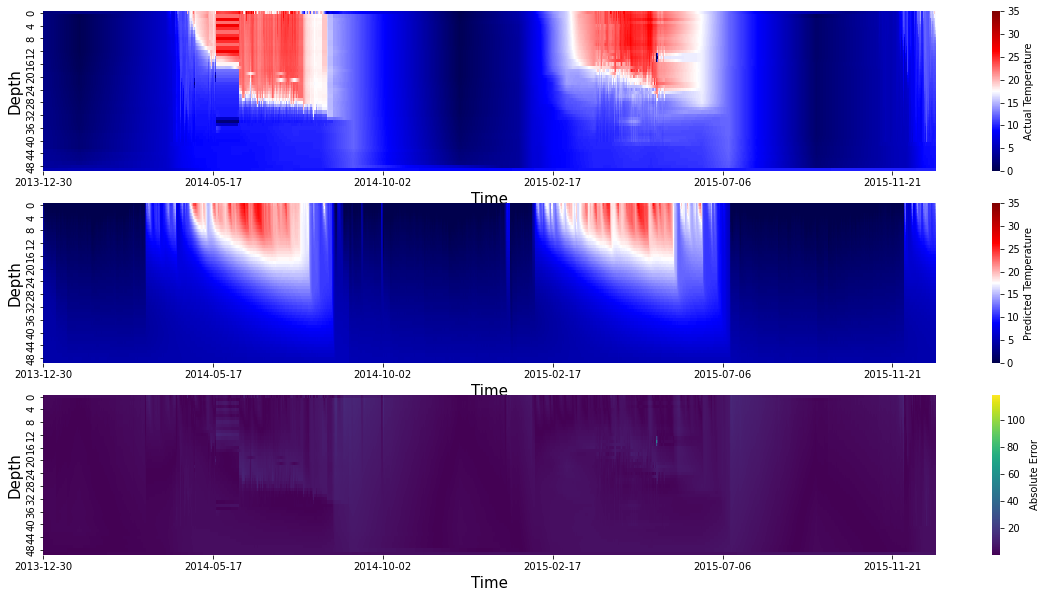

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.006863302
RMSE of after m1 0.013929524
RMSE of after m3 0.01628491
RMSE of after m4 0.018457312
RMSE of after m0 0.009060999
RMSE of after m1 0.043272562
RMSE of after m3 0.041507896
RMSE of after m4 0.042830747
RMSE of after m0 0.005133433
RMSE of after m1 0.020626914
RMSE of after m3 0.029742751
RMSE of after m4 0.02934814
RMSE of after m0 0.004748032
RMSE of after m1 0.01330695
RMSE of after m3 0.022621086
RMSE of after m4 0.022598548
RMSE of after m0 0.0032971555
RMSE of after m1 0.019172275
RMSE of after m3 0.015120118
RMSE of after m4 0.015673455
RMSE of after m0 0.01318171
RMSE of after m1 0.017276358
RMSE of after m3 0.018814266
RMSE of after m4 0.020089038
RMSE of after m0 0.0054630763
RMSE of after m1 0.014242657
RMSE of after m3 0.019269623
RMSE of after m4 0.020954702
RMSE of after m0 0.0050682533
RMSE of after m1 0.013669614
RMSE of after m3 0.018034399
RMSE of after m4 0.01958878
RMSE of after m0 0.004329502
RMSE of after m1 0.012751587
RMSE of after m3

RMSE of after m1 0.022638062
RMSE of after m3 0.018876174
RMSE of after m4 0.020044023
RMSE of after m0 0.008270175
RMSE of after m1 0.031383917
RMSE of after m3 0.039975
RMSE of after m4 0.04064705
RMSE of after m0 0.0053301593
RMSE of after m1 0.012811974
RMSE of after m3 0.015837653
RMSE of after m4 0.018273331
RMSE of after m0 0.006143303
RMSE of after m1 0.016272217
RMSE of after m3 0.019219462
RMSE of after m4 0.020764815
RMSE of after m0 0.0067290855
RMSE of after m1 0.015385869
RMSE of after m3 0.0148122795
RMSE of after m4 0.0177273
RMSE of after m0 0.0058033634
RMSE of after m1 0.01843861
RMSE of after m3 0.017365474
RMSE of after m4 0.019999985
RMSE of after m0 0.0058530453
RMSE of after m1 0.016603863
RMSE of after m3 0.017452057
RMSE of after m4 0.01935959
RMSE of after m0 0.005637668
RMSE of after m1 0.014968239
RMSE of after m3 0.015911683
RMSE of after m4 0.017863907
RMSE of after m0 0.009483862
RMSE of after m1 0.03265574
RMSE of after m3 0.044162292
RMSE of after m4 0

RMSE of after m1 0.015776398
RMSE of after m3 0.019814357
RMSE of after m4 0.019645361
RMSE of after m0 0.0077725323
RMSE of after m1 0.011567708
RMSE of after m3 0.030088149
RMSE of after m4 0.03011854
RMSE of after m0 0.009877871
RMSE of after m1 0.01133895
RMSE of after m3 0.02793093
RMSE of after m4 0.028244892
RMSE of after m0 0.0077293115
RMSE of after m1 0.014533393
RMSE of after m3 0.029067522
RMSE of after m4 0.029209264
RMSE of after m0 0.006909614
RMSE of after m1 0.026089333
RMSE of after m3 0.037343293
RMSE of after m4 0.037908096
RMSE of after m0 0.0040381365
RMSE of after m1 0.012460783
RMSE of after m3 0.028260136
RMSE of after m4 0.027835589
RMSE of after m0 0.008494147
RMSE of after m1 0.036889113
RMSE of after m3 0.042553466
RMSE of after m4 0.042893134
RMSE of after m0 0.0040980247
RMSE of after m1 0.019049484
RMSE of after m3 0.023733776
RMSE of after m4 0.023837056
RMSE of after m0 0.0036495035
RMSE of after m1 0.0077809673
RMSE of after m3 0.023388727
RMSE of aft

RMSE of after m4 0.04334329
RMSE of after m0 0.021925002
RMSE of after m1 0.06133982
RMSE of after m3 0.06296452
RMSE of after m4 0.102322094
RMSE of after m0 0.015468841
RMSE of after m1 0.03951322
RMSE of after m3 0.043547302
RMSE of after m4 0.074120075
RMSE of after m0 0.010306865
RMSE of after m1 0.029957678
RMSE of after m3 0.0345365
RMSE of after m4 0.058544286
RMSE of after m0 0.0057197236
RMSE of after m1 0.017497623
RMSE of after m3 0.021796295
RMSE of after m4 0.028272705
RMSE of after m0 0.007602628
RMSE of after m1 0.029239932
RMSE of after m3 0.033332318
RMSE of after m4 0.049826216
RMSE of after m0 0.007878875
RMSE of after m1 0.03188685
RMSE of after m3 0.036075234
RMSE of after m4 0.05079554
RMSE of after m0 0.0069068763
RMSE of after m1 0.040748186
RMSE of after m3 0.04104868
RMSE of after m4 0.04389128
RMSE of after m0 0.007689097
RMSE of after m1 0.014230074
RMSE of after m3 0.017264832
RMSE of after m4 0.020264825
RMSE of after m0 0.0061024213
RMSE of after m1 0.03

RMSE of after m3 0.021030406
RMSE of after m4 0.025241401
RMSE of after m0 0.006074544
RMSE of after m1 0.015800403
RMSE of after m3 0.022875797
RMSE of after m4 0.026131453
RMSE of after m0 0.00548286
RMSE of after m1 0.014942096
RMSE of after m3 0.019005468
RMSE of after m4 0.023862096
RMSE of after m0 0.0058795935
RMSE of after m1 0.015705323
RMSE of after m3 0.01992197
RMSE of after m4 0.021347415
RMSE of after m0 0.00629821
RMSE of after m1 0.012763009
RMSE of after m3 0.017873857
RMSE of after m4 0.01991222
RMSE of after m0 0.009284377
RMSE of after m1 0.07403637
RMSE of after m3 0.07619343
RMSE of after m4 0.078463085
RMSE of after m0 0.016513515
RMSE of after m1 0.10341482
RMSE of after m3 0.105486386
RMSE of after m4 0.110695995
RMSE of after m0 0.010082905
RMSE of after m1 0.023580445
RMSE of after m3 0.030176967
RMSE of after m4 0.0395067
RMSE of after m0 0.0072312476
RMSE of after m1 0.015750058
RMSE of after m3 0.022876287
RMSE of after m4 0.024746645
RMSE of after m0 0.00

RMSE of after m4 0.02006555
RMSE of after m0 0.013541632
RMSE of after m1 0.016736433
RMSE of after m3 0.020563537
RMSE of after m4 0.02264229
RMSE of after m0 0.008929203
RMSE of after m1 0.02274582
RMSE of after m3 0.02614171
RMSE of after m4 0.028036281
RMSE of after m0 0.0061572823
RMSE of after m1 0.017873093
RMSE of after m3 0.018313492
RMSE of after m4 0.020105505
RMSE of after m0 0.0040583606
RMSE of after m1 0.014592521
RMSE of after m3 0.015234341
RMSE of after m4 0.017376898
RMSE of after m0 0.004272078
RMSE of after m1 0.012707327
RMSE of after m3 0.015381752
RMSE of after m4 0.016933365
RMSE of after m0 0.004595589
RMSE of after m1 0.012546119
RMSE of after m3 0.014375276
RMSE of after m4 0.014556077
RMSE of after m0 0.0071963267
RMSE of after m1 0.023752607
RMSE of after m3 0.030888317
RMSE of after m4 0.031733457
RMSE of after m0 0.006146388
RMSE of after m1 0.028460156
RMSE of after m3 0.029254971
RMSE of after m4 0.030552778
RMSE of after m0 0.0043531638
RMSE of after 

RMSE of after m0 0.0057839314
RMSE of after m1 0.013753987
RMSE of after m3 0.017235886
RMSE of after m4 0.020304214
RMSE of after m0 0.0074780523
RMSE of after m1 0.02679894
RMSE of after m3 0.03450076
RMSE of after m4 0.0364742
RMSE of after m0 0.00669301
RMSE of after m1 0.023281265
RMSE of after m3 0.029733002
RMSE of after m4 0.031396803
RMSE of after m0 0.006705519
RMSE of after m1 0.02178732
RMSE of after m3 0.026965443
RMSE of after m4 0.02874354
RMSE of after m0 0.00582469
RMSE of after m1 0.015186541
RMSE of after m3 0.01880509
RMSE of after m4 0.021000275
RMSE of after m0 0.006218778
RMSE of after m1 0.02686929
RMSE of after m3 0.029008487
RMSE of after m4 0.030176148
RMSE of after m0 0.00847058
RMSE of after m1 0.030511217
RMSE of after m3 0.041938372
RMSE of after m4 0.04342021
RMSE of after m0 0.005184306
RMSE of after m1 0.019764101
RMSE of after m3 0.019746507
RMSE of after m4 0.020634778
RMSE of after m0 0.007921393
RMSE of after m1 0.013241855
RMSE of after m3 0.01617

RMSE of after m1 0.020965785
RMSE of after m3 0.026219653
RMSE of after m4 0.026626308
RMSE of after m0 0.006223972
RMSE of after m1 0.027335018
RMSE of after m3 0.037244115
RMSE of after m4 0.037446186
RMSE of after m0 0.0051477603
RMSE of after m1 0.020260321
RMSE of after m3 0.019211033
RMSE of after m4 0.020209685
RMSE of after m0 0.004626299
RMSE of after m1 0.014652221
RMSE of after m3 0.01745447
RMSE of after m4 0.018229688
RMSE of after m0 0.004690153
RMSE of after m1 0.010185538
RMSE of after m3 0.022252351
RMSE of after m4 0.022684237
RMSE of after m0 0.0038622452
RMSE of after m1 0.017646484
RMSE of after m3 0.01673284
RMSE of after m4 0.01741755
RMSE of after m0 0.0038832617
RMSE of after m1 0.013912311
RMSE of after m3 0.019603763
RMSE of after m4 0.02011268
RMSE of after m0 0.005189653
RMSE of after m1 0.010555443
RMSE of after m3 0.02410534
RMSE of after m4 0.024688827
RMSE of after m0 0.0060185636
RMSE of after m1 0.03522027
RMSE of after m3 0.05069001
RMSE of after m4 

RMSE of after m1 0.013439191
RMSE of after m3 0.014013785
RMSE of after m4 0.024992835
RMSE of after m0 0.006645211
RMSE of after m1 0.012030726
RMSE of after m3 0.011801477
RMSE of after m4 0.023608414
RMSE of after m0 0.0054520303
RMSE of after m1 0.009899757
RMSE of after m3 0.011267722
RMSE of after m4 0.020685889
RMSE of after m0 0.0055244933
RMSE of after m1 0.007463965
RMSE of after m3 0.00879449
RMSE of after m4 0.020561306
RMSE of after m0 0.0056627095
RMSE of after m1 0.06482327
RMSE of after m3 0.066516034
RMSE of after m4 0.07089684
RMSE of after m0 0.012048728
RMSE of after m1 0.051311906
RMSE of after m3 0.05291251
RMSE of after m4 0.060279287
RMSE of after m0 0.016923213
RMSE of after m1 0.021693097
RMSE of after m3 0.024783047
RMSE of after m4 0.06300609
RMSE of after m0 0.014647839
RMSE of after m1 0.023716435
RMSE of after m3 0.027873406
RMSE of after m4 0.055329386
RMSE of after m0 0.0119125405
RMSE of after m1 0.018045433
RMSE of after m3 0.021968357
RMSE of after m

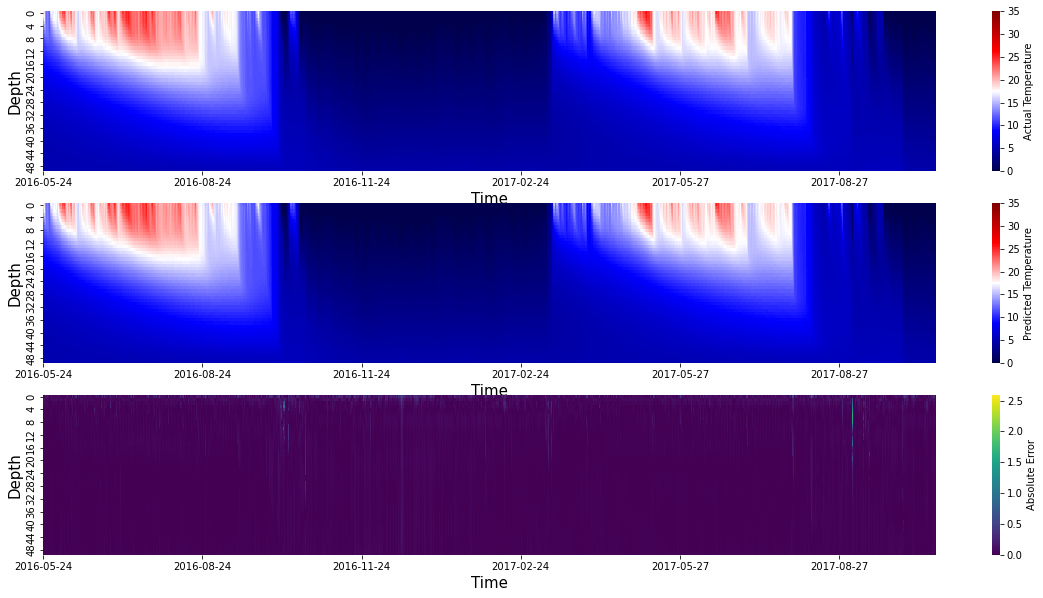

In [26]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

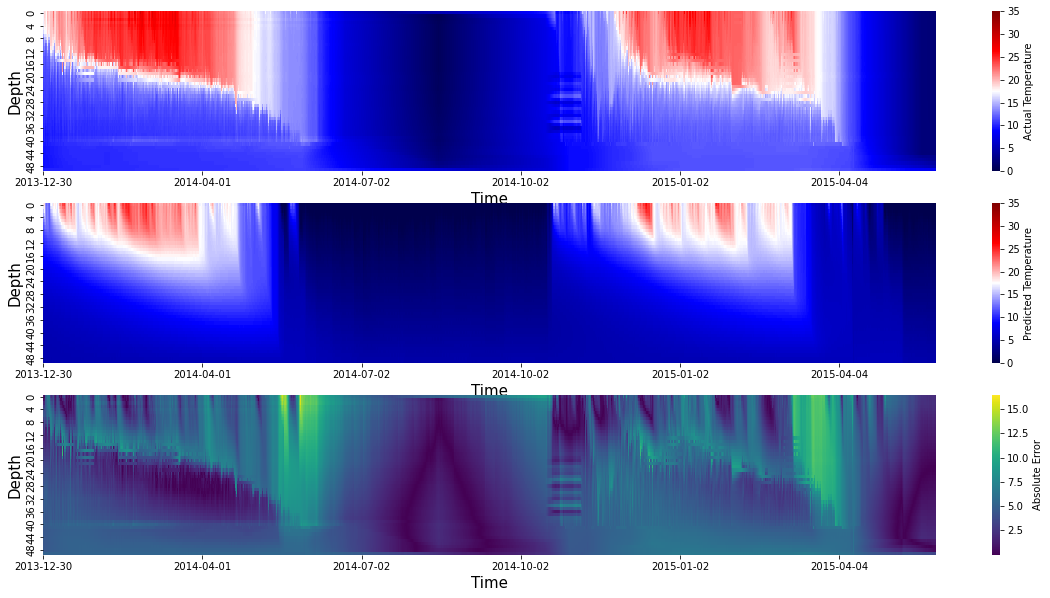

In [27]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [28]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.03122724616576825, Train L2 Error: 0.003783645600396488
Test RMSE: 0.03357528261147046, Train L2 Error: 0.00363196555112452


## Mixing Model

## Convection Model

In [29]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.019039714846999786, Train L2 Error: 0.002307114761402385
Test RMSE: 0.020407869477520577, Train L2 Error: 0.0022077638347430296


## Ice Model

In [30]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.022340894524467532, Train L2 Error: 0.0027071571487574156
Test RMSE: 0.018866212382946945, Train L2 Error: 0.0020409945564043557


# Finetuning

In [31]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [32]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [33]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [34]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m1_pred = heat_diff_model(m1_input)
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:07<2:06:07,  7.57s/it]

Epoch : 0, Train_loss: 0.5038216088353142, Loss m0: 2.443795155307724e-06, Loss m1: 0.0053628315522357,  Loss m3: 0.0053697263912015035, Loss m4: 0.5038216088353142


  5%|▌         | 51/1000 [06:24<1:54:28,  7.24s/it]

Epoch : 50, Train_loss: 0.14930454989791866, Loss m0: 2.443795155307724e-06, Loss m1: 0.36017284587648885,  Loss m3: 0.3594337721840397, Loss m4: 0.14930454989791866


 10%|█         | 101/1000 [12:26<1:48:22,  7.23s/it]

Epoch : 100, Train_loss: 0.13849308856503115, Loss m0: 2.443795155307724e-06, Loss m1: 0.37054488900517724,  Loss m3: 0.36984373745242904, Loss m4: 0.13849308856503115


 15%|█▌        | 151/1000 [18:28<1:42:01,  7.21s/it]

Epoch : 150, Train_loss: 0.13013062176032136, Loss m0: 2.443795155307724e-06, Loss m1: 0.37894056064427295,  Loss m3: 0.37827681886216363, Loss m4: 0.13013062176032136


 20%|██        | 201/1000 [24:38<1:43:40,  7.79s/it]

Epoch : 200, Train_loss: 0.12391293730817828, Loss m0: 2.443795155307724e-06, Loss m1: 0.38639381386431737,  Loss m3: 0.3857537536127599, Loss m4: 0.12391293730817828


 25%|██▌       | 251/1000 [31:00<1:32:08,  7.38s/it]

Epoch : 250, Train_loss: 0.11929531678328992, Loss m0: 2.443795155307724e-06, Loss m1: 0.39186438403761603,  Loss m3: 0.39123970232266553, Loss m4: 0.11929531678328992


 30%|███       | 301/1000 [37:24<1:29:42,  7.70s/it]

Epoch : 300, Train_loss: 0.11522958238326729, Loss m0: 2.443795155307724e-06, Loss m1: 0.39551123460407717,  Loss m3: 0.3948994455788242, Loss m4: 0.11522958238326729


 35%|███▌      | 351/1000 [43:37<1:20:23,  7.43s/it]

Epoch : 350, Train_loss: 0.11101596578605961, Loss m0: 2.443795155307724e-06, Loss m1: 0.3983123275369916,  Loss m3: 0.3977135038074148, Loss m4: 0.11101596578605961


 40%|████      | 401/1000 [49:50<1:14:31,  7.46s/it]

Epoch : 400, Train_loss: 0.1064582041871093, Loss m0: 2.443795155307724e-06, Loss m1: 0.4008160466062677,  Loss m3: 0.40023095285017113, Loss m4: 0.1064582041871093


 45%|████▌     | 451/1000 [56:03<1:07:56,  7.43s/it]

Epoch : 450, Train_loss: 0.10169571232767298, Loss m0: 2.443795155307724e-06, Loss m1: 0.40340893778121345,  Loss m3: 0.4028391859692454, Loss m4: 0.10169571232767298


 50%|█████     | 501/1000 [1:02:16<1:02:05,  7.47s/it]

Epoch : 500, Train_loss: 0.09692538935096205, Loss m0: 2.443795155307724e-06, Loss m1: 0.4063293924803063,  Loss m3: 0.40577629279741884, Loss m4: 0.09692538935096205


 55%|█████▌    | 551/1000 [1:08:29<55:46,  7.45s/it]  

Epoch : 550, Train_loss: 0.0922881670898409, Loss m0: 2.443795155307724e-06, Loss m1: 0.4097166268611787,  Loss m3: 0.4091783771309081, Loss m4: 0.0922881670898409


 60%|██████    | 601/1000 [1:14:40<49:25,  7.43s/it]

Epoch : 600, Train_loss: 0.08792875162531628, Loss m0: 2.443795155307724e-06, Loss m1: 0.41360219053307923,  Loss m3: 0.4130748605440608, Loss m4: 0.08792875162531628


 65%|██████▌   | 651/1000 [1:21:03<46:00,  7.91s/it]

Epoch : 650, Train_loss: 0.08395583844513937, Loss m0: 2.443795155307724e-06, Loss m1: 0.4179533508060918,  Loss m3: 0.41743317134536717, Loss m4: 0.08395583844513937


 70%|███████   | 701/1000 [1:27:29<37:39,  7.56s/it]

Epoch : 700, Train_loss: 0.08049300517110038, Loss m0: 2.443795155307724e-06, Loss m1: 0.422632545248708,  Loss m3: 0.42211614576780976, Loss m4: 0.08049300517110038


 75%|███████▌  | 751/1000 [1:33:41<30:52,  7.44s/it]

Epoch : 750, Train_loss: 0.07763502717473166, Loss m0: 2.443795155307724e-06, Loss m1: 0.4273590981241443,  Loss m3: 0.42684380885588974, Loss m4: 0.07763502717473166


 80%|████████  | 801/1000 [1:39:54<24:38,  7.43s/it]

Epoch : 800, Train_loss: 0.07539683818762251, Loss m0: 2.443795155307724e-06, Loss m1: 0.43175335126458014,  Loss m3: 0.4312376020982607, Loss m4: 0.07539683818762251


 85%|████████▌ | 851/1000 [1:46:06<18:26,  7.43s/it]

Epoch : 850, Train_loss: 0.07369596322891285, Loss m0: 2.443795155307724e-06, Loss m1: 0.4354690346944751,  Loss m3: 0.4349524043093191, Loss m4: 0.07369596322891285


 90%|█████████ | 901/1000 [1:52:18<12:16,  7.44s/it]

Epoch : 900, Train_loss: 0.07239878492783082, Loss m0: 2.443795155307724e-06, Loss m1: 0.43835606405461924,  Loss m3: 0.43783892550905845, Loss m4: 0.07239878492783082


 95%|█████████▌| 951/1000 [1:58:30<06:05,  7.46s/it]

Epoch : 950, Train_loss: 0.0713823005860714, Loss m0: 2.443795155307724e-06, Loss m1: 0.44048127564406836,  Loss m3: 0.4399642975940706, Loss m4: 0.0713823005860714


100%|██████████| 1000/1000 [2:04:37<00:00,  7.48s/it]


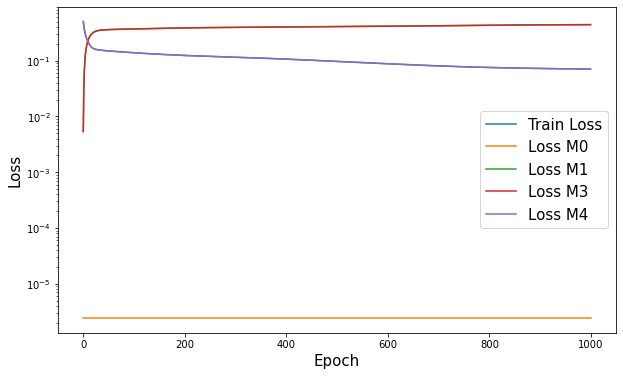

In [35]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [36]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.005494097
RMSE of after m1 2.2579875
RMSE of after m3 2.2396848
RMSE of after m4 2.237769
RMSE of after m0 0.0072544105
RMSE of after m1 2.8504436
RMSE of after m3 2.836086
RMSE of after m4 2.834571
RMSE of after m0 0.006148237
RMSE of after m1 2.223036
RMSE of after m3 2.2153482
RMSE of after m4 2.21312
RMSE of after m0 0.006151012
RMSE of after m1 1.4792454
RMSE of after m3 1.4778587
RMSE of after m4 1.4897567
RMSE of after m0 0.0035043687
RMSE of after m1 1.4774511
RMSE of after m3 1.4762548
RMSE of after m4 1.5127392
RMSE of after m0 0.0035139145
RMSE of after m1 1.4610741
RMSE of after m3 1.4600956
RMSE of after m4 1.4953854
RMSE of after m0 0.004039306
RMSE of after m1 1.4136426
RMSE of after m3 1.4127544
RMSE of after m4 1.450779
RMSE of after m0 0.0040400084
RMSE of after m1 1.4013158
RMSE of after m3 1.4006054
RMSE of after m4 1.4416368
RMSE of after m0 0.003603099
RMSE of after m1 1.3616912
RMSE of after m3 1.3608342
RMSE of after m4 1.4013308
RMSE of after

RMSE of after m0 0.0059977956
RMSE of after m1 1.2438531
RMSE of after m3 1.2476623
RMSE of after m4 1.3661023
RMSE of after m0 0.006621452
RMSE of after m1 1.24298
RMSE of after m3 1.2469656
RMSE of after m4 1.3629835
RMSE of after m0 0.006353938
RMSE of after m1 1.2475116
RMSE of after m3 1.251252
RMSE of after m4 1.3716991
RMSE of after m0 0.0058569135
RMSE of after m1 1.2614131
RMSE of after m3 1.2648759
RMSE of after m4 1.3966149
RMSE of after m0 0.0068547046
RMSE of after m1 1.2800219
RMSE of after m3 1.2836685
RMSE of after m4 1.4044155
RMSE of after m0 0.006718914
RMSE of after m1 1.3461542
RMSE of after m3 1.3496522
RMSE of after m4 1.4741699
RMSE of after m0 0.006703765
RMSE of after m1 1.4307917
RMSE of after m3 1.4346113
RMSE of after m4 1.5769558
RMSE of after m0 0.0068459744
RMSE of after m1 1.5234985
RMSE of after m3 1.5271512
RMSE of after m4 1.6985339
RMSE of after m0 0.0060490672
RMSE of after m1 1.5775023
RMSE of after m3 1.580767
RMSE of after m4 1.7696596
RMSE of a

RMSE of after m1 3.2779233
RMSE of after m3 3.2755613
RMSE of after m4 3.2820892
RMSE of after m0 0.0049196025
RMSE of after m1 3.39332
RMSE of after m3 3.3922262
RMSE of after m4 3.398436
RMSE of after m0 0.005921045
RMSE of after m1 3.3381937
RMSE of after m3 3.338209
RMSE of after m4 3.3440685
RMSE of after m0 0.005044909
RMSE of after m1 3.1672869
RMSE of after m3 3.1682093
RMSE of after m4 3.1732268
RMSE of after m0 0.0037754045
RMSE of after m1 3.2200367
RMSE of after m3 3.2202208
RMSE of after m4 3.2264495
RMSE of after m0 0.0045731063
RMSE of after m1 3.1502106
RMSE of after m3 3.14807
RMSE of after m4 3.1559587
RMSE of after m0 0.0058493256
RMSE of after m1 3.1544588
RMSE of after m3 3.1534276
RMSE of after m4 3.161343
RMSE of after m0 0.0043007964
RMSE of after m1 3.1529226
RMSE of after m3 3.151971
RMSE of after m4 3.1598117
RMSE of after m0 0.0054198853
RMSE of after m1 3.157031
RMSE of after m3 3.1568267
RMSE of after m4 3.164475
RMSE of after m0 0.0062614824
RMSE of after

RMSE of after m1 3.5051243
RMSE of after m3 3.5068307
RMSE of after m4 3.5356069
RMSE of after m0 0.0058889603
RMSE of after m1 3.5457792
RMSE of after m3 3.5458415
RMSE of after m4 3.5743883
RMSE of after m0 0.0048821126
RMSE of after m1 3.4839683
RMSE of after m3 3.483923
RMSE of after m4 3.5132952
RMSE of after m0 0.0073114918
RMSE of after m1 3.775672
RMSE of after m3 3.7773027
RMSE of after m4 3.8058844
RMSE of after m0 0.0057020816
RMSE of after m1 3.9308372
RMSE of after m3 3.930892
RMSE of after m4 3.960419
RMSE of after m0 0.0056925714
RMSE of after m1 3.7412493
RMSE of after m3 3.741443
RMSE of after m4 3.7706065
RMSE of after m0 0.0053291167
RMSE of after m1 3.5677207
RMSE of after m3 3.56599
RMSE of after m4 3.593069
RMSE of after m0 0.006495236
RMSE of after m1 3.6243577
RMSE of after m3 3.6238282
RMSE of after m4 3.6521542
RMSE of after m0 0.005323894
RMSE of after m1 3.4107778
RMSE of after m3 3.409623
RMSE of after m4 3.43859
RMSE of after m0 0.006591858
RMSE of after m

RMSE of after m3 9.616782
RMSE of after m4 9.636457
RMSE of after m0 0.00742761
RMSE of after m1 9.143308
RMSE of after m3 9.137119
RMSE of after m4 9.682677
RMSE of after m0 0.005848661
RMSE of after m1 8.933741
RMSE of after m3 8.92915
RMSE of after m4 9.559326
RMSE of after m0 0.0057000075
RMSE of after m1 9.00061
RMSE of after m3 8.996979
RMSE of after m4 9.612581
RMSE of after m0 0.008831992
RMSE of after m1 8.788431
RMSE of after m3 8.786156
RMSE of after m4 9.334622
RMSE of after m0 0.0070920913
RMSE of after m1 8.788675
RMSE of after m3 8.786267
RMSE of after m4 9.257581
RMSE of after m0 0.007952004
RMSE of after m1 9.115761
RMSE of after m3 9.113182
RMSE of after m4 9.418847
RMSE of after m0 0.0073126783
RMSE of after m1 8.927661
RMSE of after m3 8.921769
RMSE of after m4 9.370164
RMSE of after m0 0.010954203
RMSE of after m1 8.889347
RMSE of after m3 8.884882
RMSE of after m4 9.390713
RMSE of after m0 0.019902335
RMSE of after m1 8.425459
RMSE of after m3 8.421699
RMSE of aft

RMSE of after m1 3.2439399
RMSE of after m3 3.228553
RMSE of after m4 3.8908496
RMSE of after m0 0.005426041
RMSE of after m1 2.4914966
RMSE of after m3 2.4847705
RMSE of after m4 3.009678
RMSE of after m0 0.0044968
RMSE of after m1 1.7390434
RMSE of after m3 1.739534
RMSE of after m4 2.111073
RMSE of after m0 0.0074830395
RMSE of after m1 1.6381468
RMSE of after m3 1.638892
RMSE of after m4 1.9920946
RMSE of after m0 0.0054559903
RMSE of after m1 1.5705465
RMSE of after m3 1.5718858
RMSE of after m4 1.895827
RMSE of after m0 0.004300919
RMSE of after m1 1.5620421
RMSE of after m3 1.563489
RMSE of after m4 1.8823766
RMSE of after m0 0.00439756
RMSE of after m1 1.5002489
RMSE of after m3 1.5017226
RMSE of after m4 1.800648
RMSE of after m0 0.0041637802
RMSE of after m1 1.5324979
RMSE of after m3 1.5337086
RMSE of after m4 1.8272053
RMSE of after m0 0.004448592
RMSE of after m1 1.5351031
RMSE of after m3 1.5364194
RMSE of after m4 1.823853
RMSE of after m0 0.007949226
RMSE of after m1 1.

RMSE of after m0 0.0088210525
RMSE of after m1 0.9781627
RMSE of after m3 0.98208433
RMSE of after m4 1.0849137
RMSE of after m0 0.009247516
RMSE of after m1 0.97828037
RMSE of after m3 0.98218304
RMSE of after m4 1.0885739
RMSE of after m0 0.0077833054
RMSE of after m1 0.99513215
RMSE of after m3 0.9985585
RMSE of after m4 1.1097325
RMSE of after m0 0.0070674387
RMSE of after m1 1.0123764
RMSE of after m3 1.0156643
RMSE of after m4 1.1457127
RMSE of after m0 0.0068186033
RMSE of after m1 1.0067929
RMSE of after m3 1.0101266
RMSE of after m4 1.1428049
RMSE of after m0 0.0064543537
RMSE of after m1 1.0321116
RMSE of after m3 1.0354359
RMSE of after m4 1.1814129
RMSE of after m0 0.0076602474
RMSE of after m1 1.1998998
RMSE of after m3 1.2033395
RMSE of after m4 1.4077135
RMSE of after m0 0.008520973
RMSE of after m1 1.1855823
RMSE of after m3 1.1889447
RMSE of after m4 1.391719
RMSE of after m0 0.008358478
RMSE of after m1 1.2665621
RMSE of after m3 1.269457
RMSE of after m4 1.496503
RMS

RMSE of after m1 2.9532108
RMSE of after m3 2.9545665
RMSE of after m4 2.9573224
RMSE of after m0 0.0070364885
RMSE of after m1 2.9594505
RMSE of after m3 2.9614625
RMSE of after m4 2.964292
RMSE of after m0 0.004518452
RMSE of after m1 2.9220407
RMSE of after m3 2.9240828
RMSE of after m4 2.9268563
RMSE of after m0 0.019106373
RMSE of after m1 3.145107
RMSE of after m3 3.146651
RMSE of after m4 3.1496649
RMSE of after m0 0.0053022583
RMSE of after m1 3.0388675
RMSE of after m3 3.041131
RMSE of after m4 3.0434253
RMSE of after m0 0.006272259
RMSE of after m1 3.0160873
RMSE of after m3 3.016112
RMSE of after m4 3.0205216
RMSE of after m0 0.0063694166
RMSE of after m1 3.1015115
RMSE of after m3 3.101953
RMSE of after m4 3.1068318
RMSE of after m0 0.008106975
RMSE of after m1 3.0773125
RMSE of after m3 3.078659
RMSE of after m4 3.083317
RMSE of after m0 0.004379933
RMSE of after m1 3.0324705
RMSE of after m3 3.033778
RMSE of after m4 3.0381174
RMSE of after m0 0.007580222
RMSE of after m1

RMSE of after m1 4.3676605
RMSE of after m3 4.368029
RMSE of after m4 4.3875847
RMSE of after m0 0.004641424
RMSE of after m1 4.738285
RMSE of after m3 4.7356634
RMSE of after m4 4.756209
RMSE of after m0 0.0055654133
RMSE of after m1 4.6863494
RMSE of after m3 4.6830826
RMSE of after m4 4.704889
RMSE of after m0 0.005979759
RMSE of after m1 4.4016128
RMSE of after m3 4.3992424
RMSE of after m4 4.420449
RMSE of after m0 0.005828837
RMSE of after m1 4.2632685
RMSE of after m3 4.26154
RMSE of after m4 4.282223
RMSE of after m0 0.0064497218
RMSE of after m1 4.2677307
RMSE of after m3 4.2665544
RMSE of after m4 4.2878094
RMSE of after m0 0.010830933
RMSE of after m1 3.820075
RMSE of after m3 3.8197298
RMSE of after m4 3.8411787
RMSE of after m0 0.009983539
RMSE of after m1 4.1160884
RMSE of after m3 4.114078
RMSE of after m4 4.1369514
RMSE of after m0 0.007822385
RMSE of after m1 4.117182
RMSE of after m3 4.1155868
RMSE of after m4 4.1368985
RMSE of after m0 0.0071258903
RMSE of after m1 4

RMSE of after m3 4.979388
RMSE of after m4 5.000623
RMSE of after m0 0.0044910894
RMSE of after m1 5.013069
RMSE of after m3 5.0077868
RMSE of after m4 5.02814
RMSE of after m0 0.014874295
RMSE of after m1 5.0339394
RMSE of after m3 5.0268016
RMSE of after m4 5.051956
RMSE of after m0 0.0096122045
RMSE of after m1 4.506323
RMSE of after m3 4.49479
RMSE of after m4 4.5166287
RMSE of after m0 0.0051135826
RMSE of after m1 4.1293745
RMSE of after m3 4.118998
RMSE of after m4 4.1380105
RMSE of after m0 0.0049599684
RMSE of after m1 4.0724163
RMSE of after m3 4.064399
RMSE of after m4 4.0832305
RMSE of after m0 0.0054017706
RMSE of after m1 4.053682
RMSE of after m3 4.046728
RMSE of after m4 4.0664215
RMSE of after m0 0.009887687
RMSE of after m1 4.0540347
RMSE of after m3 4.0467386
RMSE of after m4 4.0685153
RMSE of after m0 0.006378631
RMSE of after m1 3.9855921
RMSE of after m3 3.9805503
RMSE of after m4 3.9998634
RMSE of after m0 0.008380715
RMSE of after m1 4.2160215
RMSE of after m3 4

RMSE of after m0 0.0079165865
RMSE of after m1 6.1420727
RMSE of after m3 6.131181
RMSE of after m4 6.69396
RMSE of after m0 0.008608015
RMSE of after m1 6.095104
RMSE of after m3 6.0849357
RMSE of after m4 6.6917534
RMSE of after m0 0.008865865
RMSE of after m1 6.060542
RMSE of after m3 6.049517
RMSE of after m4 6.670587
RMSE of after m0 0.0073648957
RMSE of after m1 6.0290785
RMSE of after m3 6.0184727
RMSE of after m4 6.6672993
RMSE of after m0 0.011085889
RMSE of after m1 5.9655147
RMSE of after m3 5.9554224
RMSE of after m4 6.631286
RMSE of after m0 0.008770828
RMSE of after m1 5.879349
RMSE of after m3 5.868254
RMSE of after m4 6.617012
RMSE of after m0 0.0065656933
RMSE of after m1 5.7329397
RMSE of after m3 5.7206097
RMSE of after m4 6.4457545
RMSE of after m0 0.011910883
RMSE of after m1 5.564817
RMSE of after m3 5.55225
RMSE of after m4 6.278089
RMSE of after m0 0.0080612
RMSE of after m1 5.7739854
RMSE of after m3 5.7629604
RMSE of after m4 6.564728
RMSE of after m0 0.006809

RMSE of after m0 0.009671748
RMSE of after m1 0.99302024
RMSE of after m3 0.996651
RMSE of after m4 1.0564497
RMSE of after m0 0.007888389
RMSE of after m1 0.94832724
RMSE of after m3 0.9520948
RMSE of after m4 1.0094378
RMSE of after m0 0.0070299623
RMSE of after m1 0.9344998
RMSE of after m3 0.9381343
RMSE of after m4 1.0019192
RMSE of after m0 0.009824638
RMSE of after m1 0.9489655
RMSE of after m3 0.95280325
RMSE of after m4 1.0073107
RMSE of after m0 0.028466458
RMSE of after m1 1.1192336
RMSE of after m3 1.1235486
RMSE of after m4 1.1133595
RMSE of after m0 0.019746609
RMSE of after m1 1.2438233
RMSE of after m3 1.2483038
RMSE of after m4 1.2911233
RMSE of after m0 0.012262952
RMSE of after m1 1.1245428
RMSE of after m3 1.1286951
RMSE of after m4 1.1704227
RMSE of after m0 0.01021958
RMSE of after m1 1.0266749
RMSE of after m3 1.0306109
RMSE of after m4 1.065396
RMSE of after m0 0.010243179
RMSE of after m1 1.0225114
RMSE of after m3 1.0264273
RMSE of after m4 1.0632036
RMSE of a

RMSE of after m4 2.853594
RMSE of after m0 0.013311199
RMSE of after m1 3.3883438
RMSE of after m3 3.3900177
RMSE of after m4 3.1694212
RMSE of after m0 0.017980104
RMSE of after m1 3.0550032
RMSE of after m3 3.0569463
RMSE of after m4 2.7753546
RMSE of after m0 0.01967264
RMSE of after m1 3.4216337
RMSE of after m3 3.4229488
RMSE of after m4 2.8624775
RMSE of after m0 0.009512297
RMSE of after m1 3.736866
RMSE of after m3 3.7384632
RMSE of after m4 3.0122824
RMSE of after m0 0.009210207
RMSE of after m1 3.7390463
RMSE of after m3 3.740718
RMSE of after m4 2.921298
RMSE of after m0 0.00826561
RMSE of after m1 3.6329734
RMSE of after m3 3.6343217
RMSE of after m4 2.7816343
RMSE of after m0 0.00874587
RMSE of after m1 3.5512254
RMSE of after m3 3.5525718
RMSE of after m4 2.6875863
RMSE of after m0 0.009812158
RMSE of after m1 3.6882882
RMSE of after m3 3.6895154
RMSE of after m4 2.7898962
RMSE of after m0 0.011493998
RMSE of after m1 3.909315
RMSE of after m3 3.9106286
RMSE of after m4 3

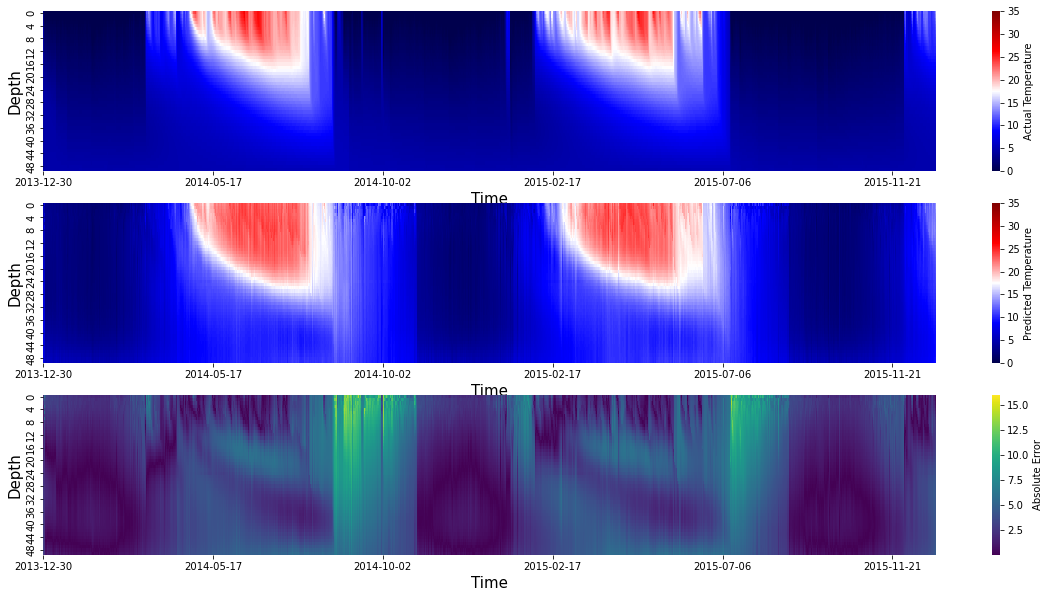

In [37]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

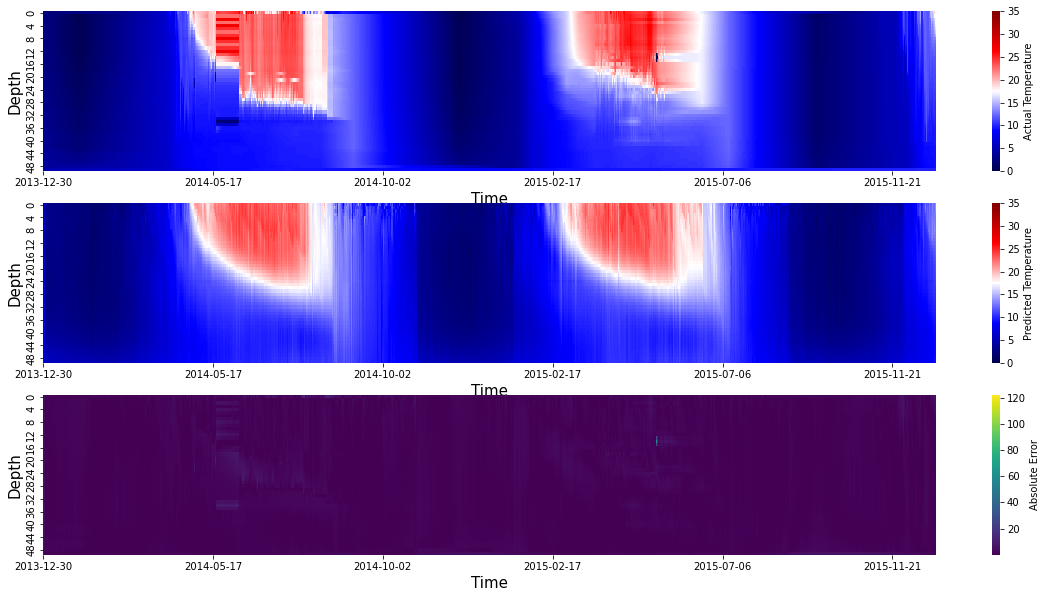

In [38]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [39]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.006863302
RMSE of after m1 3.281257
RMSE of after m3 3.2791119
RMSE of after m4 3.2860308
RMSE of after m0 0.009060999
RMSE of after m1 3.4113383
RMSE of after m3 3.408399
RMSE of after m4 3.4168365
RMSE of after m0 0.005133433
RMSE of after m1 3.4709833
RMSE of after m3 3.4691014
RMSE of after m4 3.4792683
RMSE of after m0 0.004748032
RMSE of after m1 3.3690126
RMSE of after m3 3.3684976
RMSE of after m4 3.3777668
RMSE of after m0 0.0032971555
RMSE of after m1 3.5588672
RMSE of after m3 3.5586646
RMSE of after m4 3.5677366
RMSE of after m0 0.01318171
RMSE of after m1 3.6362362
RMSE of after m3 3.6345882
RMSE of after m4 3.6447272
RMSE of after m0 0.0054630763
RMSE of after m1 3.4096756
RMSE of after m3 3.407143
RMSE of after m4 3.4156866
RMSE of after m0 0.0050682533
RMSE of after m1 3.3912683
RMSE of after m3 3.3874645
RMSE of after m4 3.3974097
RMSE of after m0 0.004329502
RMSE of after m1 3.3476877
RMSE of after m3 3.3450425
RMSE of after m4 3.354489
RMSE of afte

RMSE of after m1 3.6227517
RMSE of after m3 3.6223977
RMSE of after m4 3.6475942
RMSE of after m0 0.006840833
RMSE of after m1 3.520237
RMSE of after m3 3.521086
RMSE of after m4 3.5459664
RMSE of after m0 0.007026957
RMSE of after m1 3.533567
RMSE of after m3 3.534701
RMSE of after m4 3.5602727
RMSE of after m0 0.0091463
RMSE of after m1 3.5712543
RMSE of after m3 3.5731223
RMSE of after m4 3.5987759
RMSE of after m0 0.006466774
RMSE of after m1 3.6722121
RMSE of after m3 3.6730976
RMSE of after m4 3.6983204
RMSE of after m0 0.0055481237
RMSE of after m1 3.5942614
RMSE of after m3 3.594336
RMSE of after m4 3.6192746
RMSE of after m0 0.009531842
RMSE of after m1 3.5974092
RMSE of after m3 3.597632
RMSE of after m4 3.6230288
RMSE of after m0 0.006851582
RMSE of after m1 3.7054338
RMSE of after m3 3.705358
RMSE of after m4 3.7310717
RMSE of after m0 0.005658641
RMSE of after m1 3.7366636
RMSE of after m3 3.736519
RMSE of after m4 3.7632797
RMSE of after m0 0.0054905564
RMSE of after m1 3

RMSE of after m4 4.5172763
RMSE of after m0 0.0077293115
RMSE of after m1 3.9167016
RMSE of after m3 3.9040508
RMSE of after m4 3.922062
RMSE of after m0 0.006909614
RMSE of after m1 3.9358962
RMSE of after m3 3.9226525
RMSE of after m4 3.9399292
RMSE of after m0 0.0040381365
RMSE of after m1 3.8762949
RMSE of after m3 3.8663917
RMSE of after m4 3.8830218
RMSE of after m0 0.008494147
RMSE of after m1 4.213346
RMSE of after m3 4.2063823
RMSE of after m4 4.224446
RMSE of after m0 0.0040980247
RMSE of after m1 4.2548094
RMSE of after m3 4.2484384
RMSE of after m4 4.2666955
RMSE of after m0 0.0036495035
RMSE of after m1 4.0966744
RMSE of after m3 4.090246
RMSE of after m4 4.107743
RMSE of after m0 0.0037065519
RMSE of after m1 4.149249
RMSE of after m3 4.1410866
RMSE of after m4 4.1591063
RMSE of after m0 0.007043812
RMSE of after m1 4.1206493
RMSE of after m3 4.1155014
RMSE of after m4 4.134069
RMSE of after m0 0.0050253887
RMSE of after m1 4.2802124
RMSE of after m3 4.2728047
RMSE of aft

RMSE of after m4 4.667178
RMSE of after m0 0.015468841
RMSE of after m1 4.2421374
RMSE of after m3 4.2293305
RMSE of after m4 4.65404
RMSE of after m0 0.010306865
RMSE of after m1 4.1991253
RMSE of after m3 4.1867285
RMSE of after m4 4.6266193
RMSE of after m0 0.0057197236
RMSE of after m1 3.8723192
RMSE of after m3 3.8582726
RMSE of after m4 4.2270856
RMSE of after m0 0.007602628
RMSE of after m1 3.9337797
RMSE of after m3 3.9215221
RMSE of after m4 4.3125925
RMSE of after m0 0.007878875
RMSE of after m1 3.9224136
RMSE of after m3 3.910761
RMSE of after m4 4.31823
RMSE of after m0 0.0069068763
RMSE of after m1 3.7070827
RMSE of after m3 3.6952636
RMSE of after m4 4.114704
RMSE of after m0 0.007689097
RMSE of after m1 3.6195798
RMSE of after m3 3.6051683
RMSE of after m4 3.9482632
RMSE of after m0 0.0061024213
RMSE of after m1 3.539619
RMSE of after m3 3.527512
RMSE of after m4 3.8859062
RMSE of after m0 0.006431563
RMSE of after m1 3.4762113
RMSE of after m3 3.4639673
RMSE of after m4

RMSE of after m3 0.95149463
RMSE of after m4 1.0085273
RMSE of after m0 0.008132474
RMSE of after m1 0.933581
RMSE of after m3 0.9368509
RMSE of after m4 1.0056454
RMSE of after m0 0.0072389897
RMSE of after m1 0.9559268
RMSE of after m3 0.95853573
RMSE of after m4 1.0260911
RMSE of after m0 0.0069991183
RMSE of after m1 0.9862694
RMSE of after m3 0.98922473
RMSE of after m4 1.0867968
RMSE of after m0 0.0062816585
RMSE of after m1 0.9402755
RMSE of after m3 0.9433198
RMSE of after m4 1.0333635
RMSE of after m0 0.007339907
RMSE of after m1 1.0333872
RMSE of after m3 1.0355666
RMSE of after m4 1.121957
RMSE of after m0 0.008727352
RMSE of after m1 0.9570413
RMSE of after m3 0.96015453
RMSE of after m4 1.0190592
RMSE of after m0 0.008688572
RMSE of after m1 0.9495913
RMSE of after m3 0.95264554
RMSE of after m4 1.0156654
RMSE of after m0 0.0111576365
RMSE of after m1 0.98473555
RMSE of after m3 0.98771846
RMSE of after m4 1.0311414
RMSE of after m0 0.009737019
RMSE of after m1 1.0572635
R

RMSE of after m4 2.3913352
RMSE of after m0 0.006582103
RMSE of after m1 2.3633163
RMSE of after m3 2.3657877
RMSE of after m4 2.3676474
RMSE of after m0 0.0063593546
RMSE of after m1 2.230931
RMSE of after m3 2.2343047
RMSE of after m4 2.2355027
RMSE of after m0 0.0034275292
RMSE of after m1 2.3719845
RMSE of after m3 2.37381
RMSE of after m4 2.3764684
RMSE of after m0 0.0037227992
RMSE of after m1 2.313613
RMSE of after m3 2.3156111
RMSE of after m4 2.318174
RMSE of after m0 0.0046091415
RMSE of after m1 2.196137
RMSE of after m3 2.1982374
RMSE of after m4 2.2005033
RMSE of after m0 0.0043859696
RMSE of after m1 2.1506267
RMSE of after m3 2.1530595
RMSE of after m4 2.154722
RMSE of after m0 0.004718577
RMSE of after m1 2.1852238
RMSE of after m3 2.1884878
RMSE of after m4 2.1901953
RMSE of after m0 0.005003917
RMSE of after m1 2.2388098
RMSE of after m3 2.242047
RMSE of after m4 2.2434013
RMSE of after m0 0.007378483
RMSE of after m1 2.2865903
RMSE of after m3 2.2878127
RMSE of after

RMSE of after m1 4.312986
RMSE of after m3 4.311391
RMSE of after m4 4.325408
RMSE of after m0 0.005943417
RMSE of after m1 4.2924953
RMSE of after m3 4.2872553
RMSE of after m4 4.3042035
RMSE of after m0 0.005864191
RMSE of after m1 4.249725
RMSE of after m3 4.245472
RMSE of after m4 4.261494
RMSE of after m0 0.005667066
RMSE of after m1 4.2703543
RMSE of after m3 4.2669444
RMSE of after m4 4.2836576
RMSE of after m0 0.005171038
RMSE of after m1 4.244684
RMSE of after m3 4.2421017
RMSE of after m4 4.2587943
RMSE of after m0 0.0053403
RMSE of after m1 4.158583
RMSE of after m3 4.1571236
RMSE of after m4 4.17245
RMSE of after m0 0.005804962
RMSE of after m1 4.2028913
RMSE of after m3 4.2017846
RMSE of after m4 4.2163
RMSE of after m0 0.008514349
RMSE of after m1 4.3474627
RMSE of after m3 4.342094
RMSE of after m4 4.360782
RMSE of after m0 0.004859957
RMSE of after m1 4.1438766
RMSE of after m3 4.139709
RMSE of after m4 4.156421
RMSE of after m0 0.009501911
RMSE of after m1 4.1332426
RM

RMSE of after m4 3.915051
RMSE of after m0 0.0060693133
RMSE of after m1 3.7178411
RMSE of after m3 3.7119548
RMSE of after m4 3.7365167
RMSE of after m0 0.004578706
RMSE of after m1 3.6983297
RMSE of after m3 3.6932256
RMSE of after m4 3.7172222
RMSE of after m0 0.0040287995
RMSE of after m1 3.8641784
RMSE of after m3 3.8595555
RMSE of after m4 3.8857446
RMSE of after m0 0.007467212
RMSE of after m1 3.5589554
RMSE of after m3 3.5562232
RMSE of after m4 3.578723
RMSE of after m0 0.0064468696
RMSE of after m1 3.7458305
RMSE of after m3 3.7421956
RMSE of after m4 3.7659836
RMSE of after m0 0.0070298617
RMSE of after m1 3.9479191
RMSE of after m3 3.941317
RMSE of after m4 3.9655416
RMSE of after m0 0.0050704237
RMSE of after m1 3.8076754
RMSE of after m3 3.799971
RMSE of after m4 3.8236294
RMSE of after m0 0.006835009
RMSE of after m1 3.670927
RMSE of after m3 3.6662447
RMSE of after m4 3.688084
RMSE of after m0 0.0044194926
RMSE of after m1 3.9161513
RMSE of after m3 3.9101539
RMSE of af

RMSE of after m1 5.357401
RMSE of after m3 5.348849
RMSE of after m4 5.3558226
RMSE of after m0 0.0062681283
RMSE of after m1 5.149887
RMSE of after m3 5.14128
RMSE of after m4 5.147451
RMSE of after m0 0.0057428647
RMSE of after m1 5.5078225
RMSE of after m3 5.4947553
RMSE of after m4 5.4999804
RMSE of after m0 0.0056172432
RMSE of after m1 6.0889134
RMSE of after m3 6.079675
RMSE of after m4 6.084551
RMSE of after m0 0.007827341
RMSE of after m1 6.3133597
RMSE of after m3 6.304633
RMSE of after m4 6.63437
RMSE of after m0 0.005880177
RMSE of after m1 5.903522
RMSE of after m3 5.896173
RMSE of after m4 6.474277
RMSE of after m0 0.005843267
RMSE of after m1 5.9739375
RMSE of after m3 5.9658504
RMSE of after m4 6.516511
RMSE of after m0 0.0059468816
RMSE of after m1 6.021776
RMSE of after m3 6.013123
RMSE of after m4 6.556651
RMSE of after m0 0.006446088
RMSE of after m1 5.905327
RMSE of after m3 5.894832
RMSE of after m4 6.415115
RMSE of after m0 0.0057576946
RMSE of after m1 5.8192325

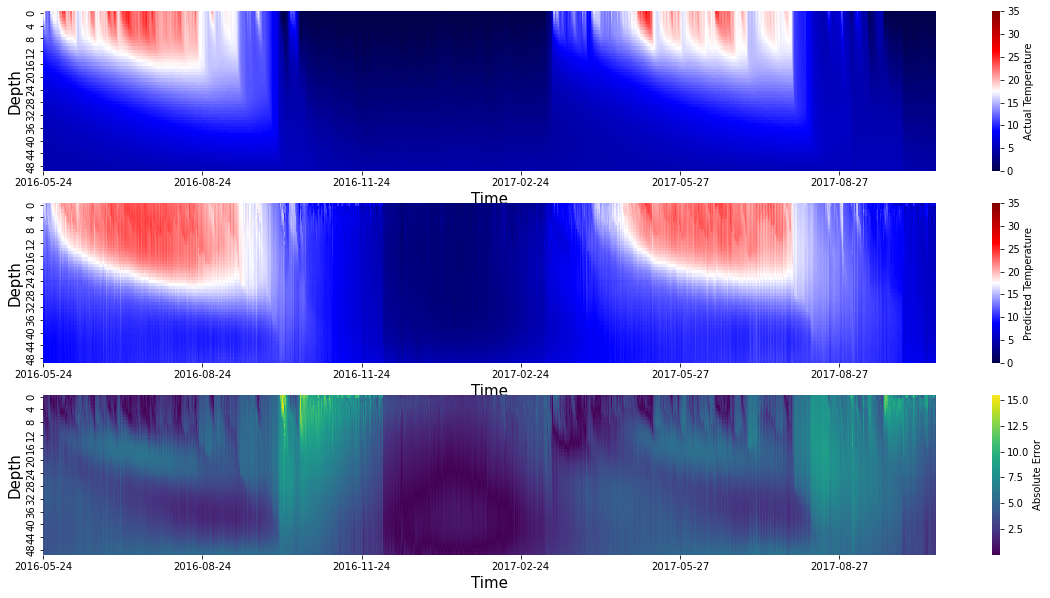

In [40]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

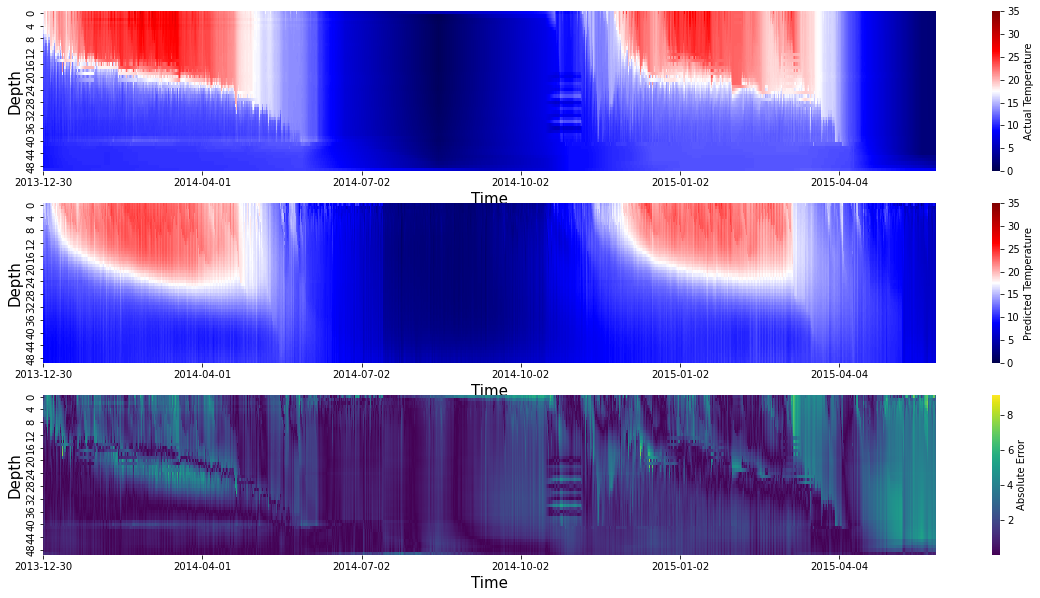

In [41]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [42]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 3.723418932411922, Train L2 Error: 0.45114761600390274
Test RMSE: 4.232663969563796, Train L2 Error: 0.4578633009537131


## Mixing Model

## Convection Model

In [43]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.019039714846999786, Train L2 Error: 0.002307114761402385
Test RMSE: 0.020407869477520577, Train L2 Error: 0.0022077638347430296


## Ice Model

In [44]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.022340894524467532, Train L2 Error: 0.0027071571487574156
Test RMSE: 0.018866212382946945, Train L2 Error: 0.0020409945564043557


# Compute Model Similarity after Finetuning

In [45]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [46]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [47]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.8699756264686584
L2 Norm: 5.81929874420166


In [48]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [49]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [50]:
# Freeze all models again and compute finetuned diffusivity values

In [51]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [52]:
PATH = f"./saved_models/diffusion_model_finetuned.pth"
torch.save(heat_diff_model.state_dict(), PATH)